In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

## 2 - Bayes estimator and Bayes risk

Question 1 (M) : Propose a supervised learning setting :
- input space X
- output space Y
- a random variable (X, Y) with a joint distribution.
- a loss function l(x, y)

l = X × Y → R+ <br>
(x, y) → l(x, y)


Compute the Bayes predictor f* : X → Y and the Bayes risk associated with this
setting. Remark : you have to use a setting different than the settings seen during
the course, in terms of input space X and output space Y. However, you can use any
classical loss function l (square loss, "0-1" loss, etc).

On se propose d'étudier le cas des prix des appatements à Paris en fonction de leur surface. <br><br>
On suppose que la surface est une variable aléatoire continue entre 9 et 100 et que le prix est suit une variable aléatoire Y = 1000*X + epsilon (epsilon étant une variable gaussienne centrée et d'écart type sigma=4000).<br><br>

On suppose que la fonction de perte est la fonction de perte quadratique.



In [2]:
# instantiate a Pseudo-random number generator (PRNG)
rng = np.random.default_rng()
n_samples = int(1e6)
X = rng.uniform(low=9, high=100, size=n_samples)
y = 1000 * X + rng.normal(loc=0, scale=4000, size=n_samples)

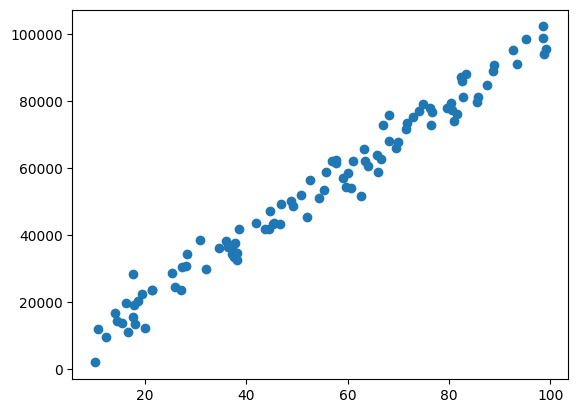

In [3]:
plt.plot(X[:100], y[:100], 'o')

Here the the Bayes predictor f* : X → Y is the function that minimizes the Bayes risk associated with this setting. <br><br>
f* = 1000*x <br>
R* = E[l(x, f*(x))] = E[(1000*x + eps - 1000*x)^2]<br>
R* = E[eps^2] = 4000**2 = 16 000 000 puisque Var(eps) = E[eps^2] - E[eps]^2 = E[eps^2] = 16 000 000 

Question 2 (C) : propose an estimator ˜f : X → Y, different than the Bayes estimator
and run a simulation that gives a statistical approximation of its generalization
error (risque réel) by computing its empirical risk on a test set. Perform the same
simulation also for f*, and verify that the generalization error is smaller for f∗ than
for ˜f, and that your computation in question 1 was correct (the test error for f∗
should be close to the Bayes risk if there is a sufficiently large number of samples).

In [4]:
y_pred_bayes = 1000 * X
y_pred_bad = 1200 * X + rng.normal(loc=100, scale=1000, size=n_samples)
risk_bayes = 4000**2

# compute the empirical risk for the Bayes estimator
empirical_risk_bayes = np.mean((y - y_pred_bayes)**2)

# empirical risk bad estimator
empirical_risk_bad_estimator = np.mean((y - y_pred_bad)**2)

print(f"Empirical risk for the Bayes estimator: {empirical_risk_bayes}")
print(f"Empirical risk for the bad estimator: {empirical_risk_bad_estimator}")
print(f"Difference between empirical risk for bad estimator and bayes risk: {abs(empirical_risk_bad_estimator - risk_bayes)}")
print(f"Difference between empirical risk for bayes estimator and bayes risk: {abs(empirical_risk_bayes - risk_bayes)}")


Empirical risk for the Bayes estimator: 15995213.26876527
Empirical risk for the bad estimator: 165570786.10571837
Difference between empirical risk for bad estimator and bayes risk: 149570786.10571837
Difference between empirical risk for bayes estimator and bayes risk: 4786.73123472929


We can conclude that the Bayes estimator f* = 1000*x is the best estimator in terms of generalization error.


## 3 - Bayes risk with Absolute Loss

### Question 1 (M + C)

In [5]:
# TODO

### Question 2 (M)

On donne
$g(z) = \int_{y\in\mathbb{R}}|y - z|p_{Y|X=x}(y)dy$ <br>

$g(z) = \int_{-\infty}^z(z-y)p_{Y|X=x}(y)dy + \int_{z}^{+\infty}(y-z)p_{Y|X=x}(y)dy$ <br>

</br>Pour trouver le minimum de $g$, on dérive par rapport à $z$ et on cherche $z$ tel que $\frac{\partial g(z)}{\partial z} = 0$.<br>

$\frac{\partial g(z)}{\partial z} = \int_{-\infty}^z p_{Y|X=x}(y)dy - \int_{z}^{+\infty} p_{Y|X=x}(y)dy$ <br>

$\frac{\partial g(z)}{\partial z} = P(Y \leq z\ |\ X=x) - P(Y \geq z\ |\ X=x)$ <br>

Nous avons donc $\frac{\partial g(z)}{\partial z} = 0$ si $P(Y \leq z\ |\ X=x) = P(Y \geq z\ |\ X=x)$ <br>

Par conséquent, $g(z)$ est minimum si $z$ est la médiane de $Y$ sachant $X=x$, soit $z = Med(Y\ |\ X=x)$.<br>

Enfin, l'estimateur de Bayes associé à l'`absolute loss` est donc $$f^*(x) = Med(Y\ |\ X=x)$$

## 5 - Regression on a given dataset

### Loading the dataset

In [6]:
# Training - Load the raw data and the associated labels
X_train = np.load('./data/regression/X_train.npy')
y_train = np.load('./data/regression/y_train.npy')

# Testing - Similarly, the raw data and the associated labels
X_test = np.load('./data/regression/X_test.npy')
y_test = np.load('./data/regression/y_test.npy')

### Regression

#### Ridge

For the Ridge regression, we have to find the $\lambda$ that minimizes the empirical risk. To that end, we use the Optunity library to find the best $\lambda$ in a specific range. After finding the best value for the parameter, we use the `R2` score as a metric to evaluate the performance of the Ridge regression.

In [7]:
# Hyperparameter search with Optuna

import optuna
from sklearn.model_selection import cross_val_score, KFold

def objective(trial):
    # Define the hyperparameter configuration space for the Ridge regressor
    alpha = trial.suggest_float('alpha', 1e-10, 1e5, log=True)

    # Define the Ridge regressor
    ridge_regressor = Ridge(alpha=alpha)

    # Fit the model to the training data
    ridge_regressor.fit(X_train, y_train)

    # Define the cross-validation folds

    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # Evaluate the model
    cross_validation_score = cross_val_score(ridge_regressor, X_train, y_train, cv=cv, n_jobs=-1).mean()

    return cross_validation_score

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')

optuna.logging.set_verbosity(optuna.logging.WARNING)

# Start the optimization
study.optimize(objective, n_trials=500, n_jobs=5, show_progress_bar=True)

# Print the optimized parameter values
print(study.best_params)
print(study.best_value)

[I 2023-06-16 17:12:22,659] A new study created in memory with name: no-name-b479e680-7198-4974-9b0e-9bd4aa16d4dc


  0%|          | 0/500 [00:00<?, ?it/s]

{'alpha': 2.0791059515822896}
0.5568448501248695


In [8]:
ridge = Ridge(**study.best_params)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R2 score: {r2:.2f}")

R2 score: 0.59


#### Lasso regression

We use the same approach as for the Ridge regression, applied to the Lasso regression. We also use the `R2` score as a metric to evaluate the performance of the Lasso regression.

In [9]:
# Same with Lasso
def objective(trial):
    # Define the hyperparameter configuration space for the Lasso regressor
    alpha = trial.suggest_float('alpha', 1e-10, 1e5, log=True)

    # Define the Lasso regressor
    lasso_regressor = Lasso(alpha=alpha, max_iter=10000, tol=1e-2)

    # Fit the model to the training data
    lasso_regressor.fit(X_train, y_train)

    # Define the cross-validation folds

    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # Evaluate the model
    cross_validation_score = cross_val_score(lasso_regressor, X_train, y_train, cv=cv, n_jobs=-1).mean()

    return cross_validation_score

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')

optuna.logging.set_verbosity(optuna.logging.ERROR)

# Start the optimization
study.optimize(objective, n_trials=500, n_jobs=5, show_progress_bar=True)

# Print the optimized parameter values
print(study.best_params)
print(study.best_value)

  0%|          | 0/500 [00:00<?, ?it/s]

{'alpha': 0.009024947659751856}
0.8718602084528546


In [10]:
lasso = Lasso(**study.best_params)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R2 score: {r2:.2f}")

R2 score: 0.88


<!-- random_forest_regressor =  -->